In [ ]:
import os
import warnings

import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torchmeta.modules import MetaModule, MetaSequential
from torchmeta.toy import Sinusoid
from torchmeta.utils.data import BatchMetaDataLoader
from torchmeta.utils.gradient_based import gradient_update_parameters
from tqdm import tqdm

warnings.filterwarnings("ignore")

In [ ]:
def get_dataloader(args):
    train_dataset = Sinusoid(
        num_samples_per_task=args.num_shots * 2,
        num_tasks=args.num_task_batch_train * args.task_batch_size,
        noise_std=None,
    )
    train_dataloader = BatchMetaDataLoader(train_dataset, batch_size=args.task_batch_size)

    val_dataset = Sinusoid(
        num_samples_per_task=args.num_shots * 2,
        num_tasks=args.num_task_batch_train * args.task_batch_size,
        noise_std=None,
    )
    val_dataloader = BatchMetaDataLoader(val_dataset, batch_size=args.task_batch_size)

    test_dataset = Sinusoid(
        num_samples_per_task=args.num_shots * 2,
        num_tasks=args.num_task_batch_test * args.task_batch_size,
        noise_std=None,
    )
    test_dataloader = BatchMetaDataLoader(test_dataset, batch_size=args.task_batch_size)
    return train_dataloader, val_dataloader, test_dataloader

In [ ]:
def save_model(output_folder: str, model: nn.Module, title: str) -> None:
    if not os.path.isdir(output_folder):
        os.mkdir(output_folder)
    filename = os.path.join(output_folder, title)

    with open(filename, "wb") as f:
        state_dict = model.state_dict()
        torch.save(state_dict, f)
    print("Model saved in", filename)


def load_model(output_folder: str, model: nn.Module, title: str) -> None:
    filename = os.path.join(output_folder, title)
    model.load_state_dict(torch.load(filename))
    print("Load model")

In [ ]:
def print_loss_graph(train_losses, val_losses):
    plt.figure(figsize=(8, 6), dpi=80)

    plt.plot(train_losses, label="train_loss")
    plt.plot(val_losses, label="val_loss")
    plt.title("Loss")
    plt.legend()

    plt.show()

In [ ]:
class FCNet(MetaModule):
    def __init__(self, in_dimension, out_dimension):
        super(FCNet, self).__init__()
        self.in_dimension = in_dimension
        self.out_dimension = out_dimension
        self.hidden_size = 40

        self.linears = MetaSequential(
            MetaLinear(1, self.hidden_size),
            nn.ReLU(),
            MetaLinear(self.hidden_size, self.hidden_size),
            nn.ReLU(),
            MetaLinear(self.hidden_size, 1),
        )

    def forward(self, x, params=None):
        pred = self.linears(x, params=self.get_subdict(params, "linears"))
        return pred

In [ ]:
def train_MAML(args, task_batch, model, criterion, optimizer):
    model.train()

    xs, ys = task_batch
    support_xs = xs[:, : args.num_shots, :].to(device=args.device).type(torch.float)
    query_xs = xs[:, args.num_shots :, :].to(device=args.device).type(torch.float)
    support_ys = ys[:, : args.num_shots, :].to(device=args.device).type(torch.float)
    query_ys = ys[:, args.num_shots :, :].to(device=args.device).type(torch.float)

    outer_loss = torch.tensor(0.0, device=args.device)

    for task_idx, (support_x, support_y, query_x, query_y) in enumerate(
        zip(support_xs, support_ys, query_xs, query_ys)
    ):
        support_pred = model(support_x)
        inner_loss = criterion(support_pred, support_y)

        params = gradient_update_parameters(model, inner_loss, step_size=0.01, first_order=False)

        query_pred = model(query_x, params=params)
        outer_loss += criterion(query_pred, query_y)

    outer_loss.div_(args.task_batch_size)
    model.zero_grad()
    outer_loss.backward()
    optimizer.step()

    return outer_loss.item()

In [ ]:
def test_MAML(args, task_batch, model, criterion, optimizer):
    model.eval()

    xs, ys = task_batch
    support_xs = xs[:, : args.num_shots, :].to(device=args.device).type(torch.float)
    query_xs = xs[:, args.num_shots :, :].to(device=args.device).type(torch.float)
    support_ys = ys[:, : args.num_shots, :].to(device=args.device).type(torch.float)
    query_ys = ys[:, args.num_shots :, :].to(device=args.device).type(torch.float)

    outer_loss = torch.tensor(0.0, device=args.device)

    for task_idx, (support_x, support_y, query_x, query_y) in enumerate(
        zip(support_xs, support_ys, query_xs, query_ys)
    ):
        support_pred = model(support_x)
        inner_loss = criterion(support_pred, support_y)

        params = gradient_update_parameters(model, inner_loss, step_size=0.01, first_order=False)

        query_pred = model(query_x, params=params)
        outer_loss += criterion(query_pred, query_y)

    outer_loss.div_(args.task_batch_size)

    return outer_loss.item()

In [ ]:
args = {
    "num_shots": 10,
    "output_folder": "model",
    "task_batch_size": 100,  # 필수
    "num_task_batch_train": 1000,  # 필수
    "num_task_batch_test": 300,  # 필수
    "device": "cuda",  # 필수
}

train_dataloader, val_dataloader, test_dataloader = get_dataloader(args)

model = FCNet(1, 1).to(device=args.device)

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

100%|██████████| 1000/1000 [05:29<00:00,  3.03it/s, train_loss=1.0611, val_loss=1.1066]


model saved in model/MAML_regression.th


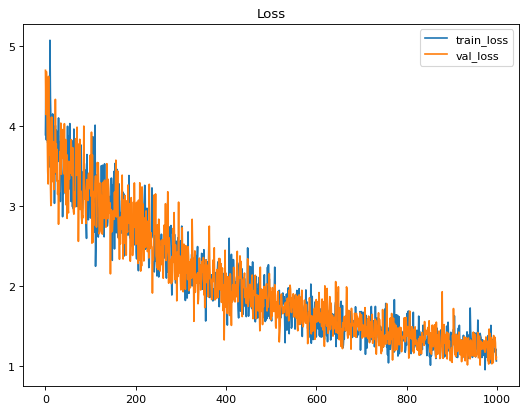

In [ ]:
# Training loop
with tqdm(zip(train_dataloader, val_dataloader), total=args.num_task_batch_train) as pbar:
    train_losses = []
    val_losses = []

    for task_batch_idx, (train_batch, val_batch) in enumerate(pbar):
        train_loss = train_MAML(args, train_batch, model, criterion, optimizer)
        val_loss = test_MAML(args, val_batch, model, criterion, optimizer)

        train_losses.append(train_loss)
        val_losses.append(val_loss)

        pbar.set_postfix(train_loss="{0:.4f}".format(train_loss), val_loss="{0:.4f}".format(val_loss))

# save model
save_model(args, model, "MAML_regression.th")
print_loss_graph(train_losses, val_losses)

In [ ]:
# load model
load_model(args, model, "MAML_regression.th")

# Testing loop
with tqdm(test_dataloader, total=args.num_task_batch_test) as pbar:
    sum_test_losses = 0.0

    for task_batch_idx, test_batch in enumerate(pbar):
        test_loss = test_MAML(args, test_batch, model, criterion, optimizer)

        sum_test_losses += test_loss
        pbar.set_postfix(test_loss="{0:.4f}".format(sum_test_losses / (task_batch_idx + 1)))

Load model from  model/MAML_regression.th


100%|██████████| 300/300 [00:38<00:00,  7.87it/s, test_loss=1.2070]
